In [32]:
data_path = "../project/unlabeled2017"
input_dir = data_path  
output_dir = "./results"
csv_filename = "metrics_cGAN.csv"

In [33]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import os
from tqdm import tqdm
import numpy as np
from torch.utils.data import DataLoader, Dataset
from skimage.color import rgb2lab, lab2rgb
import glob
import matplotlib.pyplot as plt
from models import MainModel, build_res_unet  # Ensure this matches your actual model class name
# Load the trained model
#print("hi")
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
#device = torch.device("cuda:1" if torch.cuda.device_count() > 1 else "cuda:1")  # Use GPU 1 if available

net_G = build_res_unet(n_input=1, n_output=2, size=256)
model = MainModel(net_G=net_G)
model.load_state_dict(torch.load("cGAN-unet.pt", map_location=device))  # Load trained MainModel
model.to(device)
model.eval()

# Paths

#print("hello1")
paths = sorted(glob.glob(os.path.join(data_path, "*.jpg")))[:1000]
np.random.seed(123)
paths_subset = np.random.choice(paths, len(paths), replace=False)
rand_idxs = np.random.permutation(len(paths))
val_idxs = rand_idxs 
val_paths = paths_subset[val_idxs]
#print("hello")
print("Validation set size:", len(val_paths))

# Image transformation
SIZE = 256
class ColorizationDataset(Dataset):
    def __init__(self, paths):
        self.transforms = transforms.Compose([
            transforms.Resize((SIZE, SIZE), Image.BICUBIC),
            transforms.ToTensor()
        ])
        self.paths = paths
    
    def __getitem__(self, idx):
        try:
            img = Image.open(self.paths[idx]).convert("RGB")
            img = self.transforms(img)
            img_np = np.array(img.permute(1, 2, 0))  # Convert to HWC format for rgb2lab
            img_lab = rgb2lab(img_np).astype("float32")
            img_lab = torch.tensor(img_lab).permute(2, 0, 1)  # Convert to CHW format
            L = img_lab[[0], ...] / 50. - 1.  # Normalize L
            ab = img_lab[[1, 2], ...] / 110.  # Normalize ab
            return {'L': L, 'ab': ab, 'path': self.paths[idx]}
        except Exception as e:
            print(f"Error loading image {self.paths[idx]}: {e}")
            return None  # Skip the image
    
    def __len__(self):
        return len(self.paths)

def make_dataloader(batch_size=64, num_workers=0, pin_memory=True):
    dataset = ColorizationDataset(val_paths)
    dataloader = DataLoader(dataset, batch_size=batch_size, num_workers=num_workers, pin_memory=pin_memory, drop_last=False, shuffle=False)
    return dataloader

val_dl = make_dataloader()

def colorize_validation_set():
    colorized_results = []
    for batch in tqdm(val_dl, desc="Colorizing images"):
        if batch is None:
            continue  # Skip corrupted images
        
        L, ab, paths = batch['L'].to(device), batch['ab'].to(device), batch['path']
        
        with torch.no_grad():
            pred_ab = model.net_G(L)  # Output should be ab channels
        
        for i, img_path in enumerate(paths):
            L_img = (L[i].cpu().numpy() + 1.) * 50.  # De-normalize L
            pred_ab_img = pred_ab[i].cpu().numpy() * 110.  # De-normalize ab
            lab_img = np.concatenate((L_img, pred_ab_img), axis=0).transpose(1, 2, 0)
            colorized_rgb = (lab2rgb(lab_img) * 255).astype("uint8")
            
            colorized_results.append((img_path, colorized_rgb))
    
    return colorized_results

# Run the function
colorized_images = colorize_validation_set()

/home/venkateshp/miniconda3/envs/pse_env/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/venkateshp/miniconda3/envs/pse_env/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


model initialized with norm initialization


/tmp/ipykernel_255834/2466838275.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("cGAN-unet.pt", map_location=device))  # Load trained 

Validation set size: 1000


Colorizing images:   6%|▋         | 1/16 [00:02<00:33,  2.21s/it]/home/venkateshp/miniconda3/envs/pse_env/lib/python3.8/site-packages/skimage/_shared/utils.py:394: UserWarning: Color data out of range: Z < 0 in 1 pixels
  return func(*args, **kwargs)
Colorizing images:  12%|█▎        | 2/16 [00:04<00:31,  2.21s/it]/home/venkateshp/miniconda3/envs/pse_env/lib/python3.8/site-packages/skimage/_shared/utils.py:394: UserWarning: Color data out of range: Z < 0 in 4 pixels
  return func(*args, **kwargs)
Colorizing images:  25%|██▌       | 4/16 [00:08<00:27,  2.26s/it]/home/venkateshp/miniconda3/envs/pse_env/lib/python3.8/site-packages/skimage/_shared/utils.py:394: UserWarning: Color data out of range: Z < 0 in 39 pixels
  return func(*args, **kwargs)
Colorizing images:  50%|█████     | 8/16 [00:18<00:18,  2.33s/it]/home/venkateshp/miniconda3/envs/pse_env/lib/python3.8/site-packages/skimage/_shared/utils.py:394: UserWarning: Color data out of range: Z < 0 in 5 pixels
  return func(*args, **kwa

In [37]:
import os
from PIL import Image

# Create the output directory if it doesn't exist

os.makedirs(output_dir, exist_ok=True)

# Save each colorized image
for img_path, colorized_rgb in colorized_images:
    output_path = os.path.join(output_dir, os.path.basename(img_path))
    colorized_image = Image.fromarray(colorized_rgb)
    colorized_image.save(output_path)

print(f"Colorized images saved to {output_dir}")

Colorized images saved to ./results


Evaluation

In [ ]:
import os
import numpy as np
from PIL import Image


original_img_paths = [os.path.join(input_dir, file_name) for file_name in os.listdir(input_dir)[:1000] if os.path.isfile(os.path.join(input_dir, file_name))]
# original_img_paths = sorted(glob.glob(input_dir))[:1000]
#original input that is assumed to be coloured

def load_images_from_directory(path):
    """
    Load all images from a directory into a list.

    Args:
        path (str): The path to the directory containing images.

    Returns:
        list: A list of PIL.Image objects.
    """
    images = []
    for file_name in os.listdir(path):
        file_path = os.path.join(path, file_name)
        if os.path.isfile(file_path):
            try:
                img = Image.open(file_path)
                img = np.array(img)
                images.append(img)
            except Exception as e:
                print(f"Error loading image {file_name}: {e}")
    return images

colorized_images = load_images_from_directory(output_dir)[:1000]


In [44]:
original_img_paths = sorted(glob.glob(os.path.join(input_dir, "*.jpg")))[:1000]

colorized_images_paths = sorted(glob.glob(os.path.join(output_dir, "*.jpg")))
colorized_images = [np.array(Image.open(file_path)) for file_path in colorized_images_paths]

In [39]:
print(original_img_paths[0],colorized_images_paths[0])

../project/unlabeled2017/000000000008.jpg ./results/000000000008.jpg


### SSIM

Processing Batches:   0%|          | 0/16 [00:00<?, ?batch/s]

Processing Batches: 100%|██████████| 16/16 [00:28<00:00,  1.77s/batch]



SSIM results saved to metrics_cGAN.csv

SSIM Summary Statistics:
count    1000.000000
mean        0.809752
std         0.069183
min         0.550705
25%         0.768374
50%         0.818372
75%         0.856982
max         0.982891
Name: SSIM, dtype: float64


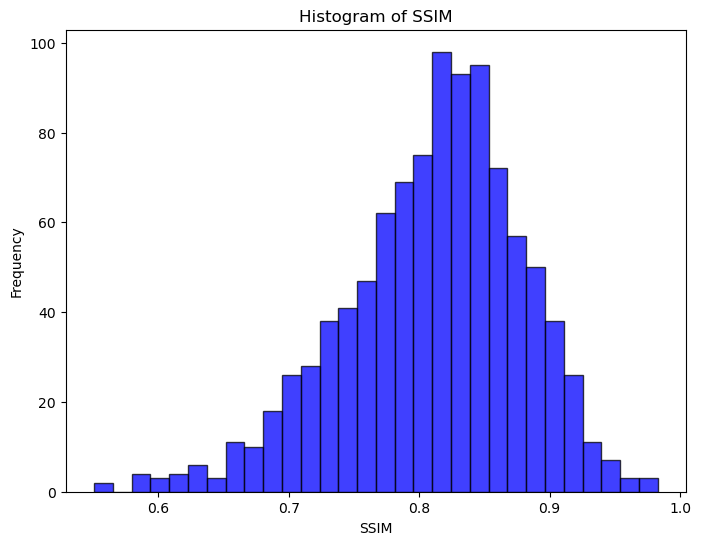


Histogram saved as ssim_histogram.png


In [43]:
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
from tqdm import tqdm

# --- Define SSIM Function ---
def compute_ssim(original, colorized):
    """Computes SSIM between two color images with the size of colorized image."""
    height, width, _ = colorized.shape  # Get dimensions of the colorized image
    original_resized = cv2.resize(original, (width, height), interpolation=cv2.INTER_CUBIC)
    
    return ssim(original_resized, colorized, data_range=255, channel_axis=2)

# --- Compute SSIM for All Images ---
ssim_values = []
batch_size = 64  # Number of images per batch

for i in tqdm(range(0, len(original_img_paths), batch_size), desc="Processing Batches", unit="batch"):
    batch_original = original_img_paths[i:i+batch_size]
    batch_colorized = colorized_images_paths[i:i+batch_size]
    # print(batch_original)
    # print(batch_colorized)
    
    for orig_path, colorized_rgb in zip(batch_original, batch_colorized):
        try:
            original_rgb = cv2.imread(orig_path)  # Load original image
            original_rgb = cv2.cvtColor(original_rgb, cv2.COLOR_BGR2RGB)  # Convert to RGB

            colorized_rgb = cv2.imread(colorized_rgb)  # Load original image
            colorized_rgb = cv2.cvtColor(colorized_rgb, cv2.COLOR_BGR2RGB)  # Convert to RGB
            
            # Compute SSIM
            ssim_val = compute_ssim(original_rgb, colorized_rgb)
            ssim_values.append((orig_path, ssim_val))
        except Exception as e:
            print(f"Skipping {orig_path} due to error: {e}")
            ssim_values.append((orig_path, np.nan))

# --- Save SSIM Results to a New CSV ---
ssim_df = pd.DataFrame(ssim_values, columns=["Image Path", "SSIM"])
ssim_df.to_csv(csv_filename, index=False)
print(f"\nSSIM results saved to {csv_filename}")

# --- Compute Summary Statistics ---
summary_stats = ssim_df["SSIM"].describe()
print("\nSSIM Summary Statistics:")
print(summary_stats)

# --- Plot Histogram for SSIM ---
plt.figure(figsize=(8, 6))
plt.hist(ssim_df["SSIM"].dropna(), bins=30, alpha=0.75, color='b', edgecolor='black')
plt.title("Histogram of SSIM")
plt.xlabel("SSIM")
plt.ylabel("Frequency")
plt.savefig("ssim_histogram.png")
plt.show()
print("\nHistogram saved as ssim_histogram.png")


Processing Batches:   0%|          | 0/100 [00:00<?, ?batch/s]

Processing Batches: 100%|██████████| 100/100 [00:49<00:00,  2.03batch/s]



Updated CSV saved as metrics_cGAN.csv

Summary Statistics:
       count      mean       std       min       25%       50%       75%  \
SSIM  1000.0  0.809752  0.069183  0.550705  0.768374  0.818372  0.856982   
PCQI  1000.0  1.724097  0.442419  0.458127  1.492287  1.757982  1.997847   

           max  
SSIM  0.982891  
PCQI  3.461067  


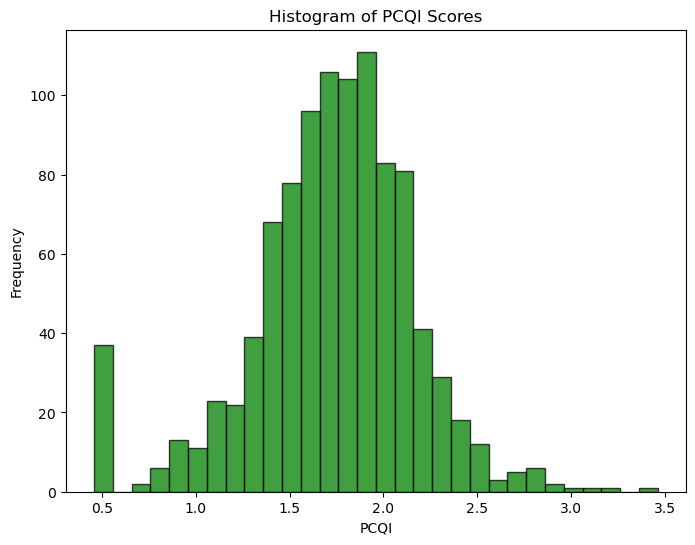


Histogram saved as colorization_metrics_histogram_pcqi.png


In [45]:
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from skimage.metrics import structural_similarity as ssim
from scipy.ndimage import gaussian_filter
import torchvision.transforms as transforms
from PIL import Image
import os

# --- Define PCQI Function ---
def compute_pcqi(original, colorized, sigma=1.5):
    """Computes PCQI (Perception-based Contrast Quality Index) for color images."""

    # Convert images to YIQ color space
    original_yiq = cv2.cvtColor(original, cv2.COLOR_RGB2YCrCb)
    colorized_yiq = cv2.cvtColor(colorized, cv2.COLOR_RGB2YCrCb)

    # Extract luminance (Y) and chrominance (I, Q) channels
    Y_orig, I_orig, Q_orig = cv2.split(original_yiq)
    Y_col, I_col, Q_col = cv2.split(colorized_yiq)

    # --- Compute Structural Similarity Index (SSIM) for Luminance ---
    luminance_similarity = ssim(Y_orig, Y_col, data_range=Y_orig.max() - Y_orig.min())

    # --- Compute Chrominance Similarity ---
    def chroma_similarity(channel_orig, channel_col):
        mu_x = gaussian_filter(channel_orig, sigma)
        mu_y = gaussian_filter(channel_col, sigma)
        sigma_x = np.sqrt(gaussian_filter(channel_orig**2, sigma) - mu_x**2)
        sigma_y = np.sqrt(gaussian_filter(channel_col**2, sigma) - mu_y**2)
        contrast_measure = (2 * sigma_x * sigma_y) / (sigma_x**2 + sigma_y**2 + 1e-6)
        structure_measure = (2 * mu_x * mu_y) / (mu_x**2 + mu_y**2 + 1e-6)
        return np.mean(contrast_measure * structure_measure)

    I_similarity = chroma_similarity(I_orig, I_col)
    Q_similarity = chroma_similarity(Q_orig, Q_col)
    chrominance_similarity = (I_similarity + Q_similarity) / 2

    # --- Final PCQI Score ---
    pcqi_score = 0.5 * luminance_similarity + 0.5 * chrominance_similarity
    return pcqi_score


if os.path.exists(csv_filename):
    df = pd.read_csv(csv_filename)  # Load existing file
else:
    df = pd.DataFrame(columns=["Image Path"])  # Create new if not found

# --- Compute PCQI for All Images in Batches ---
batch_size = 10  # Number of images per batch
new_metrics = {}

for i in tqdm(range(0, len(original_img_paths), batch_size), desc="Processing Batches", unit="batch"):
    batch_original = original_img_paths[i:i+batch_size]
    batch_colorized = colorized_images[i:i+batch_size]

    for orig_path, colorized_rgb in zip(batch_original, batch_colorized):
        original_rgb = Image.open(orig_path).convert("RGB")  # Load original grayscale image as RGB
        colorized_rgb = Image.fromarray(colorized_rgb)

        # Get dimensions of the colorized image
        width, height = colorized_rgb.size
        transform = transforms.Compose([
            transforms.Resize((height, width), Image.BICUBIC),
            transforms.ToTensor()
        ])

        # Resize images using the defined transform
        original_rgb = transform(original_rgb).permute(1, 2, 0).numpy()
        colorized_rgb = transform(colorized_rgb).permute(1, 2, 0).numpy()

        # Convert images back to uint8 for OpenCV functions
        original_rgb = (original_rgb * 255).astype(np.uint8)
        colorized_rgb = (colorized_rgb * 255).astype(np.uint8)

        pcqi_val = compute_pcqi(original_rgb, colorized_rgb)
        new_metrics[orig_path] = pcqi_val

# --- Update DataFrame with PCQI Scores ---
df["PCQI"] = df["Image Path"].map(new_metrics)  # Map new values to existing entries

# --- Save Updated CSV ---
df.to_csv(csv_filename, index=False)
print(f"\nUpdated CSV saved as {csv_filename}")

# --- Compute and Display Summary Statistics ---
summary_stats = df.drop(columns=["Image Path"]).describe().T
print("\nSummary Statistics:")
print(summary_stats)

# --- Plot Histogram for PCQI Scores ---
plt.figure(figsize=(8, 6))
plt.hist(df["PCQI"].dropna(), bins=30, alpha=0.75, color='g', edgecolor='black')
plt.title("Histogram of PCQI Scores")
plt.xlabel("PCQI")
plt.ylabel("Frequency")
plt.savefig("colorization_metrics_histogram_pcqi.png")
plt.show()
print("\nHistogram saved as colorization_metrics_histogram_pcqi.png")


Processing Batches:   0%|          | 0/16 [00:00<?, ?batch/s]

Processing Batches: 100%|██████████| 16/16 [00:06<00:00,  2.37batch/s]



Updated CSV saved as metrics_cGAN.csv

Summary Statistics:
               count        mean        std        min         25%  \
SSIM          1000.0    0.809752   0.069183   0.550705    0.768374   
PCQI          1000.0    1.724097   0.442419   0.458127    1.492287   
Colorfulness  1000.0  135.874711  36.432042  35.633408  108.512784   

                     50%         75%         max  
SSIM            0.818372    0.856982    0.982891  
PCQI            1.757982    1.997847    3.461067  
Colorfulness  146.439133  164.849701  192.022793  


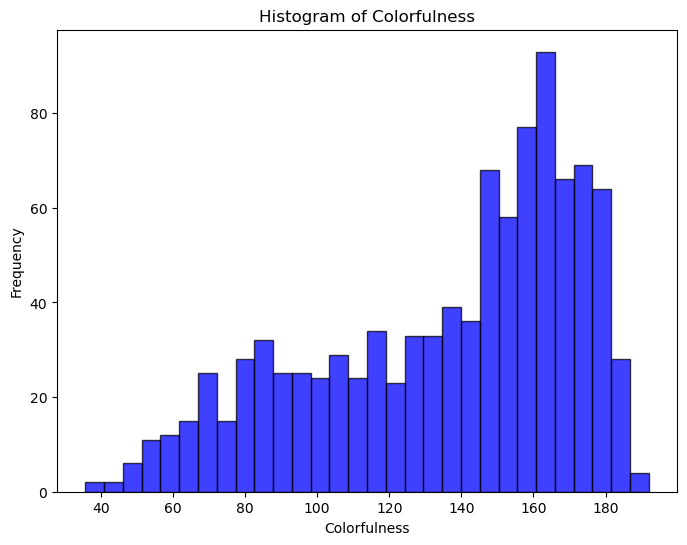


Histogram saved as colorization_colorfulness_histogram.png


In [46]:
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

# --- Define Metric Function ---
def compute_colorfulness(image):
    """Computes the Colorfulness Index (CI)."""
    (R, G, B) = cv2.split(image)
    rg = np.abs(R - G)
    yb = np.abs(0.5 * (R + G) - B)
    std_rg, std_yb = np.std(rg), np.std(yb)
    mean_rg, mean_yb = np.mean(rg), np.mean(yb)
    return np.sqrt(std_rg**2 + std_yb**2) + (0.3 * np.sqrt(mean_rg**2 + mean_yb**2))


try:
    df = pd.read_csv(csv_filename)  # Load existing CSV
except FileNotFoundError:
    df = pd.DataFrame(columns=["Image Path"])  # Create new if not found

# --- Compute Colorfulness for Each Image ---
batch_size = 64  # Number of images per batch
new_metrics = {}

for i in tqdm(range(0, len(original_img_paths), batch_size), desc="Processing Batches", unit="batch"):
    batch_original = original_img_paths[i:i+batch_size]
    batch_colorized = colorized_images[i:i+batch_size]

    for orig_path, colorized_rgb in zip(batch_original, batch_colorized):
        # Get dimensions of the colorized image
        height, width, _ = colorized_rgb.shape
        
        # Resize the original image to match colorized image size
        original_rgb = cv2.imread(orig_path)
        original_rgb = cv2.cvtColor(original_rgb, cv2.COLOR_BGR2RGB)
        original_rgb = cv2.resize(original_rgb, (width, height), interpolation=cv2.INTER_CUBIC)
        
        ci = compute_colorfulness(colorized_rgb)
        new_metrics[orig_path] = ci

# --- Update the Existing DataFrame ---
df["Colorfulness"] = df["Image Path"].map(new_metrics)  # Map new values

# --- Save Updated CSV ---
df.to_csv(csv_filename, index=False)
print(f"\nUpdated CSV saved as {csv_filename}")

# --- Compute and Display Summary Statistics ---
summary_stats = df.drop(columns=["Image Path"]).describe().T
print("\nSummary Statistics:")
print(summary_stats)

# --- Plot Histogram for Colorfulness ---
plt.figure(figsize=(8, 6))
plt.hist(df["Colorfulness"].dropna(), bins=30, alpha=0.75, color='b', edgecolor='black')
plt.title("Histogram of Colorfulness")
plt.xlabel("Colorfulness")
plt.ylabel("Frequency")
plt.savefig("colorization_colorfulness_histogram.png")
plt.show()
print("\nHistogram saved as colorization_colorfulness_histogram.png")


Processing Batches: 100%|██████████| 16/16 [00:00<00:00, 26.65batch/s]



Updated CSV saved as metrics_cGAN.csv

Summary Statistics:
                count        mean        std        min         25%  \
SSIM           1000.0    0.809752   0.069183   0.550705    0.768374   
PCQI           1000.0    1.724097   0.442419   0.458127    1.492287   
Colorfulness   1000.0  135.874711  36.432042  35.633408  108.512784   
Color Harmony  1000.0    0.007106   0.070927   0.000146    0.000409   

                      50%         75%         max  
SSIM             0.818372    0.856982    0.982891  
PCQI             1.757982    1.997847    3.461067  
Colorfulness   146.439133  164.849701  192.022793  
Color Harmony    0.000590    0.001137    1.000000  


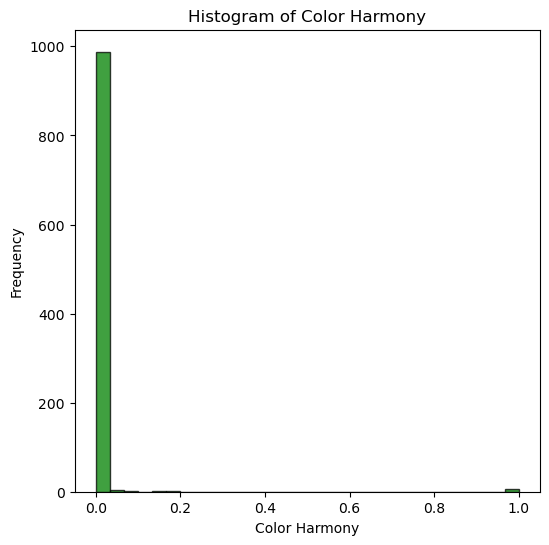


Histogram saved as colorization_metrics_histogram.png


In [47]:
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

# --- Define Metric Function ---
def compute_color_harmony(image):
    """Computes a color harmony score based on hue variance."""
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    hue = hsv[:, :, 0].flatten()
    hue_variance = np.var(hue)
    return 1 / (1 + hue_variance)


try:
    df = pd.read_csv(csv_filename)  # Load existing CSV
except FileNotFoundError:
    df = pd.DataFrame(columns=["Image Path"])  # Create new if not found

# --- Compute Color Harmony for Each Image ---
batch_size = 64  # Number of images per batch
new_metrics = {}

for i in tqdm(range(0, len(original_img_paths), batch_size), desc="Processing Batches", unit="batch"):
    batch_original = original_img_paths[i:i+batch_size]
    batch_colorized = colorized_images[i:i+batch_size]

    for img_path, colorized_rgb in zip(batch_original, batch_colorized):
        harmony = compute_color_harmony(colorized_rgb)
        new_metrics[img_path] = harmony

# --- Update the Existing DataFrame ---
df["Color Harmony"] = df["Image Path"].map(new_metrics)  # Map new values

# --- Save Updated CSV ---
df.to_csv(csv_filename, index=False)
print(f"\nUpdated CSV saved as {csv_filename}")

# --- Compute and Display Summary Statistics ---
summary_stats = df.drop(columns=["Image Path"]).describe().T
print("\nSummary Statistics:")
print(summary_stats)

# --- Plot Histogram for Color Harmony ---
plt.figure(figsize=(6, 6))
plt.hist(df["Color Harmony"].dropna(), bins=30, alpha=0.75, color='g', edgecolor='black')
plt.title("Histogram of Color Harmony")
plt.xlabel("Color Harmony")
plt.ylabel("Frequency")
plt.savefig("colorization_metrics_histogram.png")
plt.show()
print("\nHistogram saved as colorization_metrics_histogram.png")


Processing Batches: 100%|██████████| 16/16 [00:00<00:00, 48.19batch/s]



Updated CSV saved as metrics_cGAN.csv

Summary Statistics:
                             count        mean        std        min  \
SSIM                        1000.0    0.809752   0.069183   0.550705   
PCQI                        1000.0    1.724097   0.442419   0.458127   
Colorfulness                1000.0  135.874711  36.432042  35.633408   
Color Harmony               1000.0    0.007106   0.070927   0.000146   
Color Distribution Balance  1000.0    1.654933   0.188922   1.000000   

                                   25%         50%         75%         max  
SSIM                          0.768374    0.818372    0.856982    0.982891  
PCQI                          1.492287    1.757982    1.997847    3.461067  
Colorfulness                108.512784  146.439133  164.849701  192.022793  
Color Harmony                 0.000409    0.000590    0.001137    1.000000  
Color Distribution Balance    1.566532    1.700162    1.788183    1.951893  


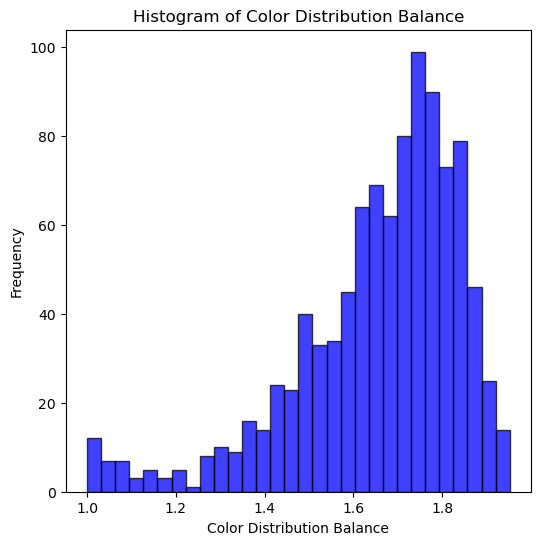


Histogram saved as colorization_metrics_histogram.png


In [48]:
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

# --- Define Metric Function ---
def compute_color_distribution_balance(image, num_bins=32):
    """Computes color distribution balance using histogram entropy."""
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    h_hist = cv2.calcHist([hsv], [0], None, [num_bins], [0, 180])
    h_hist = h_hist / np.sum(h_hist)  # Normalize histogram
    return 1 - np.sum(h_hist * np.log(h_hist + 1e-6)) / np.log(num_bins)


try:
    df = pd.read_csv(csv_filename)  # Load existing CSV
except FileNotFoundError:
    df = pd.DataFrame(columns=["Image Path"])  # Create new if not found

# --- Compute Color Distribution Balance for Each Image ---
batch_size = 64  # Number of images per batch
new_metrics = {}

for i in tqdm(range(0, len(original_img_paths), batch_size), desc="Processing Batches", unit="batch"):
    batch_original = original_img_paths[i:i+batch_size]
    batch_colorized = colorized_images[i:i+batch_size]

    for img_path, colorized_rgb in zip(batch_original, batch_colorized):
        balance = compute_color_distribution_balance(colorized_rgb)
        new_metrics[img_path] = balance

# --- Update the Existing DataFrame ---
df["Color Distribution Balance"] = df["Image Path"].map(new_metrics)  # Map new values

# --- Save Updated CSV ---
df.to_csv(csv_filename, index=False)
print(f"\nUpdated CSV saved as {csv_filename}")

# --- Compute and Display Summary Statistics ---
summary_stats = df.drop(columns=["Image Path"]).describe().T
print("\nSummary Statistics:")
print(summary_stats)

# --- Plot Histogram for Color Distribution Balance ---
plt.figure(figsize=(6, 6))
plt.hist(df["Color Distribution Balance"].dropna(), bins=30, alpha=0.75, color='b', edgecolor='black')
plt.title("Histogram of Color Distribution Balance")
plt.xlabel("Color Distribution Balance")
plt.ylabel("Frequency")
plt.savefig("colorization_metrics_histogram.png")
plt.show()
print("\nHistogram saved as colorization_metrics_histogram.png")
